In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import sys

In [ ]:
left = np.ones((495,))
middle = np.ones((10,))
right = np.ones((495,))
np.concatenate((left, middle, right), axis=0).shape

(1000,)

In [ ]:
a = 0.1
V0 = 2
m = 1
h_bar = 1

number_of_states = 1000
max_e = 20
x_std_2 = h_bar/2

position = np.linspace(-30, 30, 1000)
delta_x = 60/1000

x_bar = -a - 12*np.sqrt(x_std_2)
p_bar = 4

speed = 1
fps = 30

In [ ]:
def calc_k(e) :
  global V0, m, h_bar
  if e < V0:
    return np.sqrt((2*m)*(V0 - e))/h_bar
  elif e > V0:
    return np.sqrt((2*m)*(e - V0))/h_bar
  else:
    raise ValueError("e = V0")

def calc_kappa(e) :
  global m, h_bar
  return np.sqrt((2*m)*e)/h_bar

def calc_reverse_kappa(kappa):
  global m, h_bar
  return ((kappa*h_bar)**2)/2*m

def calc_r(e, k, kappa):
  global V0, m, h_bar, a
  if e < V0:
    numerator = (kappa**2 + k**2)*(np.exp(-k*a) - np.exp(3*k*a))
    denominator = (kappa**2 - k**2)*((np.exp(-k*a) - np.exp(3*k*a))) - 2j*k*kappa*(np.exp(-k*a) + np.exp(3*k*a))
  elif e > V0:
    numerator = (kappa**2 - k**2)*(np.sin(2*k*a))
    denominator = (kappa**2 + k**2)*np.sin(2*k*a) + 2j*k*kappa*np.cos(2*k*a)
  else:
    raise ValueError("e = V0")

  return (numerator/denominator)*np.exp(-2j*kappa*a)

def calc_t(e, k, kappa):
  global V0, m, h_bar
  if e < V0:
    numerator = 2j*kappa*(-2*k)*np.exp(k*a)
    denominator = (kappa**2 - k**2)*((np.exp(-k*a) - np.exp(3*k*a))) - 2j*k*kappa*(np.exp(-k*a) + np.exp(3*k*a))
  elif e > V0:
    numerator = 2j*kappa*k
    denominator = (kappa**2 + k**2)*np.sin(2*k*a) + 2j*k*kappa*np.cos(2*k*a)
  else:
    raise ValueError("e = V0")

  return (numerator/denominator)*np.exp(-2j*kappa*a)

def calc_c(e, k, kappa, f):
  global V0, m, h_bar
  if e < V0:
    landa = 1j*kappa - k
    landa_conj = -1j*kappa - k
    denominator = ((landa + landa_conj)/landa_conj)*np.exp(k*a)*np.exp(-1j*kappa*a)
    return f/denominator
  elif e > V0:
    numerator = (2j*kappa*np.exp(-1j*kappa*a))*(k*np.cos(k*a) -1j*kappa*np.sin(k*a))
    denominator = (k**2 + kappa**2)*np.sin(2*k*a) + 2j*kappa*k*np.cos(2*k*a)
    return numerator/denominator
  else:
    raise ValueError("e = V0")

def calc_d(e, c, k, kappa):
  global V0, m, h_bar
  if e < V0:
    landa = 1j*kappa - k
    landa_conj = -1j*kappa -k
    return c*landa*np.exp(2*k*a)/landa_conj
  elif e > V0:
    numerator = k*np.sin(k*a) + 1j*kappa*np.cos(k*a)
    denominator = k*np.cos(k*a) - 1j*kappa*np.sin(k*a)
    return c*numerator/denominator
  else:
    raise ValueError("e = V0")

def psi(x: np.ndarray, e) :
  global a, V0, m, h_bar

  k = calc_k(e)
  kappa = calc_kappa(e)
  r = calc_r(e, k, kappa)
  t = calc_t(e, k, kappa)
  c = calc_c(e, k, kappa, t)
  d = calc_d(e, c, k, kappa)

  left_region = x[x < -a]
  middle_region = x[(-a <= x) & (x <= a)]
  right_region = x[x > a]

  if e < V0:
    left_region = np.exp(1j*kappa*left_region) + r*np.exp(-1j*kappa*left_region)
    middle_region = c*np.exp(k*middle_region) + d*np.exp(-k*middle_region)
    right_region = t*np.exp(1j*kappa*right_region)

  elif e > V0:
    left_region = np.exp(1j*kappa*left_region) + r*np.exp(-1j*kappa*left_region)
    middle_region = c*np.cos(k*middle_region) + d*np.sin(-k*middle_region)
    right_region = t*np.exp(1j*kappa*right_region)
  else:
    raise ValueError("e = V0")

  return (1/np.sqrt(2*np.pi)) * np.concatenate((left_region, middle_region, right_region), axis=0), r, kappa

def initial_psi(x: np.ndarray):
  global h_bar, x_bar, p_bar, x_std_2
  momentum = np.exp(1j*p_bar*x/h_bar)
  normal = np.exp(-(x-x_bar)**2 / (4*x_std_2))
  return (np.pow(2*np.pi*x_std_2, -0.25)) * momentum * normal

def calc_coef(kappa, r):
  global h_bar, x_bar, p_bar, x_std_2
  momentum_1 = np.exp(1j*((p_bar/h_bar) - kappa)*x_bar)
  normal_1 = np.exp((-((p_bar/h_bar) - kappa)**2)*x_std_2)
  momentum_2 = np.exp(1j*((p_bar/h_bar) + kappa)*x_bar)
  normal_2 = np.exp((-((p_bar/h_bar) + kappa)**2)*x_std_2)

  return (np.pow(2*np.pi*(1/(4*x_std_2)), -0.25))*(momentum_1*normal_1 + r*momentum_2*normal_2)

def potential(x: np.ndarray):
  global V0, a
  v = np.zeros_like(x)
  v[(-a <= x) & (x <= a)] = V0
  return v

def time_component(t, e):
  global h_bar
  return np.exp(-1j*e*t/h_bar)

def calc_collide_time():
  global m, p_bar, x_std_2
  return (12*np.sqrt(x_std_2)*m/p_bar)

Now the main program starts.

In [ ]:
psi_0 = initial_psi(position)
v_x = potential(position)
c_k = np.ndarray((number_of_states,), complex)
psi_e_s = np.ndarray((number_of_states, 1000), complex)
energies = np.ndarray((number_of_states,), float)

max_kappa = calc_kappa(max_e)
delta_kappa = max_kappa/number_of_states
kappa = delta_kappa

for i in range(number_of_states):
  energy = calc_reverse_kappa(kappa)

  if energy == V0:
    energies[i] = energy
    c_k[i] = 0
    psi_e_s[i] = np.zeros((1000,), complex)
    sys.stderr.write("Encountered E = V0!!!")
    sys.stderr.flush()
  else:
    energies[i] = energy
    psi_e, r, kappa = psi(position, energy)
    c_k[i] = calc_coef(kappa, r)
    psi_e_s[i] = psi_e

  sys.stdout.write("\033[K")
  sys.stdout.write(f'\rInitial Progress: {(i*100/number_of_states):2.2f}%')
  sys.stdout.flush()

  kappa += delta_kappa

normalization_factor = 1/(np.sqrt((np.conj(c_k).T @ c_k)*delta_kappa))
print(f'\n norm factor: {normalization_factor}')
c_k *= normalization_factor
print(f'\nc_k after: {(np.conj(c_k).T @ c_k)*delta_kappa}')
simulation_time = 5*calc_collide_time()
number_of_frames = int(simulation_time*fps/speed)

fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(-30, 30)
psi_norm, = ax.plot([], [], label=r'$\psi^{*}\times\psi$')
psi_real, = ax.plot([], [], label=r'$Re\{\psi\}$')
psi_img, = ax.plot([], [], label=r'$Img\{\psi\}$')
v_plot, = ax.plot([], [], label=r'$V(x)$')

legend = ax.legend(loc='upper right')

print(f'\nintegral of actual psi: {(np.conj(psi_0).T @ psi_0) * delta_x}')
app_psi = (c_k * delta_kappa) @ psi_e_s
print(f'\nintegral of app psi: {(np.conj(app_psi).T @ app_psi) * delta_x}')

def init():
  norm = (np.conj(psi_0)*psi_0).real
  psi_norm.set_data(position, norm)
  psi_real.set_data(position, psi_0.real)
  psi_img.set_data(position, psi_0.imag)
  v_plot.set_data(position, v_x)

  return (psi_norm, psi_real, psi_img, v_plot, *legend.get_lines(), *legend.get_texts())

def animate(frame):
  time = frame*simulation_time/number_of_frames
  time_evolution = time_component(time, energies)
  c_evolution = c_k * time_evolution * delta_kappa
  psi_evolution = c_evolution @ psi_e_s


  ax.set_title(f't = {time:2.2f}')
  norm = (np.conj(psi_evolution)*psi_evolution).real
  psi_norm.set_ydata(norm)
  psi_real.set_ydata(psi_evolution.real)
  psi_img.set_ydata(psi_evolution.imag)

  sys.stdout.write("\033[K")
  sys.stdout.write(f'\rProgress: {(frame*100/number_of_frames):2.2f}%, number of frames: {number_of_frames}, current: {frame}, approximate collidance time: {simulation_time}')
  sys.stdout.flush()

  return (psi_norm, psi_real, psi_img, *legend.get_lines(), *legend.get_texts())

plt.tight_layout()
ani = FuncAnimation(fig, animate, frames=number_of_frames, init_func=init, blit=True)
writer = FFMpegWriter(fps=fps, bitrate=5000)
ani.save(f'simulation_pbar_{p_bar:2.2f}_a_{a:2.2f}_V0_{V0:2.2f}_time_{simulation_time:2.2f}.mp4', writer=writer, dpi=300)

plt.close()

print('\nSimulation completed.')

Initial Progress: 99.90%
 norm factor: (1.000248875145966+0j)

c_k after: (0.9999999999999999+0j)

integral of actual psi: (0.9990000000000003+0j)

integral of app psi: (0.998971385911168+0j)
Progress: 99.69%, number of frames: 318, current: 317, approximate collidance time: 10.606601717798213
Simulation completed.


(0.9990000000000003+0j)


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


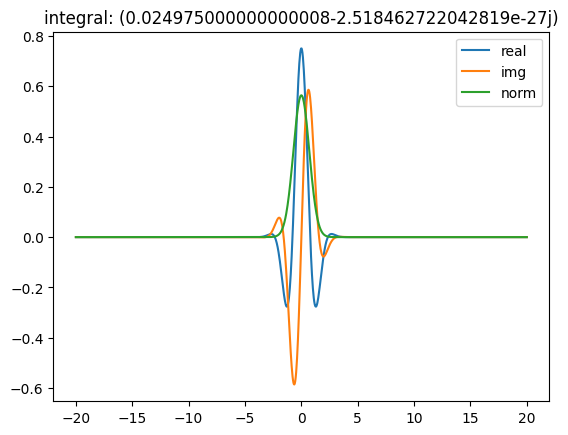

In [ ]:
x  = np.linspace(-20, 20, 1000)
func = initial_psi(x)
print((np.conj(func).T @ func)*(40/1000))
plt.plot(x, func.real, label="real")
plt.plot(x, func.imag, label="img")
plt.plot(x, np.conj(func)*func, label="norm")
plt.title(f'integral: {((np.conj(func)*func)@np.ones(x.shape[0], complex))/x.shape[0]}')
plt.legend()
plt.show()

In [ ]:
integral = np.trapz(np.abs(func)**2, x)
print(integral)

0.9999999999999999


<ipython-input-31-050bfeea9148>:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(np.abs(func)**2, x)
